**Installation Of Required Package**



Before proceeding with the implementation of this model, it is essential to install the FastF1 package. FastF1 is a comprehensive Python library that provides access to Formula 1 telemetry, timing data, and session information through the Ergast API and F1’s official data sources.

This package enables the retrieval and analysis of detailed race data, which is a critical component for the functioning of this model. By installing FastF1, we ensure that the necessary tools and data structures are in place to support data-driven analysis and predictions related to Formula 1 sessions.

To install the package, use the following command:



In [ ]:
pip install fastf1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.0/165.0 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.0/70.0 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existing installation: websockets 15.0.1
    Uninstalling websockets-15.0.1:
      Successfully uninstalled websockets-15.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.13.0 requires websockets<16.0.0,>=15.0.1, but you have websockets 13.1 which is incompatible.
dataproc-spark-connect 0.8.3 requires websockets>=14.0, but you have websockets 13.1 which is incompatible.


In [ ]:
import os

**Installation of Machine Learning and Data Analysis Libraries**


To ensure the successful development and execution of this model, it is important to install a set of essential Python libraries that support data preprocessing, visualization, and machine learning workflows.



In [ ]:
pip install pandas matplotlib scikit-learn

In [ ]:
import pandas as pd

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import fastf1

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
from sklearn.metrics import confusion_matrix

First, Create the cache directory then enable the cache

In [32]:
os.makedirs('/content/f1_cache', exist_ok=True)

In [33]:
fastf1.Cache.enable_cache('/content/f1_cache')

Create the cache directory first then enable the cache



In [ ]:
os.makedirs('/content/f1_cache', exist_ok=True)

**🏁 F1 Session Terminology**

Code  – Session  – What It means


FP1 = Free Practice 1 – first practice session

FP2 = Free Practice 2 – second practice session

FP3 = Free Practice 3 – third practice session

Q = Qualifying – sets the grid positions for the race

R = Race – the main Grand Prix where points are scored

S = Sprint – a short race that sets the grid for the main race (on sprint weekends)

SQ = Sprint Qualifying – qualifying session that sets the grid for the Sprint

In [41]:
import logging
logging.getLogger('fastf1').setLevel(logging.WARNING)


In [42]:
session= ['FP1','FP2','FP3']
all_sessions={}
for s in session:
  try:
    se=fastf1.get_session(2021,'Dutch Grand Prix',s)
    se.load()
    all_sessions[s]=se
    print(f"Loaded Session : {s}")
  except Exception as e:
    print(f"Error loading {s}: {e}")

core        WARNING 	Fixed incorrect tyre stint information for driver '16'


Loaded Session : FP1
Loaded Session : FP2
Loaded Session : FP3


**Features**


*   Average Lap Time
*   Sector Time

*   Speeds





In [80]:
race = fastf1.get_session(2021, 'Dutch Grand Prix', 'R')
race.load()

core        WARNING 	Driver 33 completed the race distance 00:00.012000 before the recorded end of the session.


In [111]:
laps = race.laps
results = race.results[['DriverNumber', 'Abbreviation', 'Status']]

results['Failure'] = results['Status'].apply( lambda x: 1 if ('Accident' in x or 'DNF' in x or 'Power Unit' in x) else 0 )

def failure_label(status):
    if (status == 'Finished') or ('+' in str(status)):
        return 0
    else:
        return 1

results['Failure'] = results['Status'].apply(failure_label)

/tmp/ipython-input-2907330989.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Failure'] = results['Status'].apply( lambda x: 1 if ('Accident' in x or 'DNF' in x or 'Power Unit' in x) else 0 )
/tmp/ipython-input-2907330989.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Failure'] = results['Status'].apply(failure_label)


In [84]:
print(results[['Abbreviation', 'Status', 'Failure']])

   Abbreviation      Status  Failure
33          VER    Finished        0
44          HAM    Finished        0
77          BOT    Finished        0
10          GAS      +1 Lap        0
16          LEC      +1 Lap        0
14          ALO      +1 Lap        0
55          SAI      +1 Lap        0
11          PER      +1 Lap        0
31          OCO      +1 Lap        0
4           NOR      +1 Lap        0
3           RIC      +1 Lap        0
18          STR     +2 Laps        0
5           VET     +2 Laps        0
99          GIO     +2 Laps        0
88          KUB     +2 Laps        0
6           LAT     +2 Laps        0
63          RUS     Gearbox        1
47          MSC     +3 Laps        0
22          TSU  Power Unit        1
9           MAZ  Hydraulics        1


In [59]:
features = laps.groupby("Driver")[ ["LapTime","Sector1Time","Sector2Time","Sector3Time","SpeedI1","SpeedI2","SpeedFL"]].mean().reset_index()

In [85]:
print(laps.columns)

Index(['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
       'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
       'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest',
       'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
       'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate'],
      dtype='object')


In [61]:
for column in ["LapTime","Sector1Time","Sector2Time","Sector3Time"]:
  features[column]=features[column].dt.total_seconds()
features.head()

,Driver,LapTime,Sector1Time,Sector2Time,Sector3Time,SpeedI1,SpeedI2,SpeedFL
0,ALO,90.723417,33.163750,29.994333,27.645867,227.933333,247.800000,273.166667
1,BOT,96.238769,34.679077,30.440000,30.642437,254.529412,240.411765,271.636364
2,GAS,94.070059,33.390944,31.965619,28.112850,225.761905,248.476190,272.277778
3,GIO,91.932312,32.513176,31.308000,28.733842,213.684211,232.789474,279.062500
4,HAM,93.734167,33.522667,31.913182,28.139182,225.619048,244.181818,266.823529


In [62]:
data = features.merge(results, left_on="Driver", right_on="Abbreviation")
data.head()

,Driver,LapTime,Sector1Time,Sector2Time,Sector3Time,SpeedI1,SpeedI2,SpeedFL,DriverNumber,Abbreviation,Status,Failure
0,ALO,90.723417,33.163750,29.994333,27.645867,227.933333,247.800000,273.166667,14,ALO,,0
1,BOT,96.238769,34.679077,30.440000,30.642437,254.529412,240.411765,271.636364,77,BOT,,0
2,GAS,94.070059,33.390944,31.965619,28.112850,225.761905,248.476190,272.277778,10,GAS,,0
3,GIO,91.932312,32.513176,31.308000,28.733842,213.684211,232.789474,279.062500,99,GIO,,0
4,HAM,93.734167,33.522667,31.913182,28.139182,225.619048,244.181818,266.823529,44,HAM,,0


In [63]:
print(data[["Driver", "LapTime", "SpeedI1", "Failure"]].head())

  Driver    LapTime     SpeedI1  Failure
0    ALO  90.723417  227.933333        0
1    BOT  96.238769  254.529412        0
2    GAS  94.070059  225.761905        0
3    GIO  91.932312  213.684211        0
4    HAM  93.734167  225.619048        0


**Train & Evaluation of The Model**

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [65]:
y=data["Failure"]

In [66]:
X=data[["LapTime","Sector1Time","Sector2Time","Sector3Time","SpeedI1","SpeedI2","SpeedFL"]]

In [67]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.3, random_state=42)

In [78]:
model=RandomForestClassifier(n_estimators = 100, random_state=42, class_weight="balanced")
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [109]:
y_pred = model.predict(X_test)

In [110]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6

[[6]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


**BONUS : Accuracy & Precision Of The Model**

In [107]:
from sklearn.metrics import precision_score, recall_score, f1_score
print(f"Train Accuracy: {model.score(X_train, y_train)*100:.2f}%")

Train Accuracy: 100.00%


In [108]:
print(f"Test Accuracy: {model.score(X_test, y_test)*100:.2f}%")

Test Accuracy: 100.00%


In [103]:
print(f"Precision: {precision_score(y_test, y_pred, zero_division=0):.2f}")

Precision: 0.00


In [104]:
print(f"Recall: {recall_score(y_test, y_pred, zero_division=0):.2f}")

Recall: 0.00


In [105]:
print(f"F1 Score: {f1_score(y_test, y_pred, zero_division=0):.2f}")

F1 Score: 0.00


In [106]:
print("Failure distribution in dataset:\n", y.value_counts())

Failure distribution in dataset:
 Failure
0    20
Name: count, dtype: int64


In [96]:
from sklearn.metrics import accuracy_score
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")

Accuracy: 100.00%


BONUS 2 : Visualize

In [97]:
import seaborn as sns

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


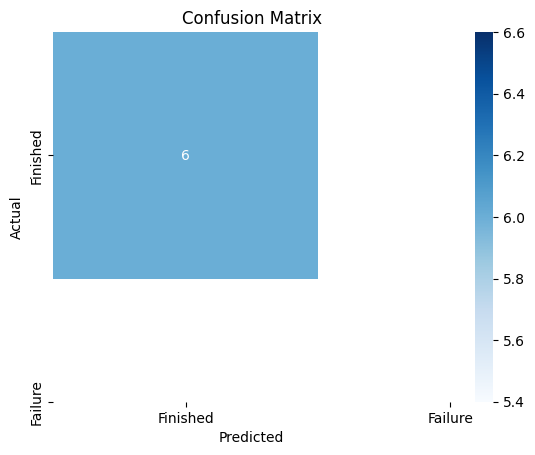

In [98]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, cmap = "Blues", xticklabels = ["Finished", "Failure"] , yticklabels = ["Finished","Failure"] )
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()